In [1]:
import numpy as np
import matplotlib.pyplot as plt

from whittle_estimator import ThomasWhittleEstimator
from spatial_pp import SPP_HomPoisson, SPP_Thomas
from minimum_contrast import MinimumContrastThomas
from palm_likelihood import PalmLikelihoodThomas
from clustering_algorithms import KMeansEstimation

In [124]:
area = 1

def taper_ft_default(p, q):
        """
        FT of default taper function, to be used if no taper given. Parameters:

        - p, q: wave function values.
        """
        
        if ((p == 0) & (q == 0)):
            t = area
        elif ((p == 0) & (q != 0)):
            t = np.sin(np.pi * q) * cmath.rect(1, -np.pi * q) / (np.pi * q)
        elif ((p != 0) & (q == 0)):
            t = np.sin(np.pi * p) * cmath.rect(1, -np.pi * p) / (np.pi * p)
        else:
            t = (np.sin(np.pi * p) * np.sin(np.pi * q) *
                cmath.rect(1, -np.pi * p - np.pi * q) /
                (p * q * np.pi ** 2))
        
        t = t * (1 / np.sqrt(area))

        return np.array([t.real, t.imag])

taper_ft_default(0, 2).sum()

-3.898171832519377e-17

In [110]:
cmath.rect(1,np.pi) * 10

(-10+1.2246467991473533e-15j)

In [85]:
import cmath


TypeError: must be real number, not list

# Thomas process

## Minimum contrast estimation
### Stability of estimates

Here we run $N_{mc}$ iterations of the minimum contrast esimator, each time sampling from a Thomas process with fixed parameter values from iteration to iteration. We use a grid of 100 uniformly spaced points between 0 and 0.125 for the integration over $r$. Parameters are either sampled using a random grid search between provided bounds, or using a uniform grid between the same bounds.

In [7]:
rho = 25 # parent Poisson intensity
K = 10 # number of Offpsring Poisson rate
sigma = 0.03 # sd of offspring spatial distribution
cov = np.array([[1, 0], [0, 1]]) 

# Instatiate class for Thomas process
tom = SPP_Thomas()

N_mc = 250 # Number of repetitions

# Run N_mc iterations of minimum contrast and plot diagnostics
params = np.zeros((N_mc, 3))
for j in range(N_mc):
    if ((j / 50) == (j // 50)):
        print(f"Iteration: {j}")
    spp = tom.simSPP(rho, K, sigma, cov, enlarge=1.25)
    mct = MinimumContrastThomas(spp)
    samp_params = mct.minimumContrastEstimate(
        rho_min=10, rho_max=50, sig_min=0.01, sig_max=0.1,
        random=True, verbose=False, coarseness=100)
    params[j,:] = samp_params

Iteration: 0
Iteration: 50
Iteration: 100
Iteration: 150
Iteration: 200


In [8]:
print(f"""
        rho mean scaled bias: {np.mean((params[:,0]- rho)/rho)}
        K mean scaled bias: {np.mean((params[:,1]- K)/K)}
        sigma mean scaled bias: {np.mean((params[:,2]- sigma)/sigma)}
       """)


        rho mean scaled bias: 0.25880461356467976
        K mean scaled bias: -0.15367240079815916
        sigma mean scaled bias: -0.07028496289823846
       


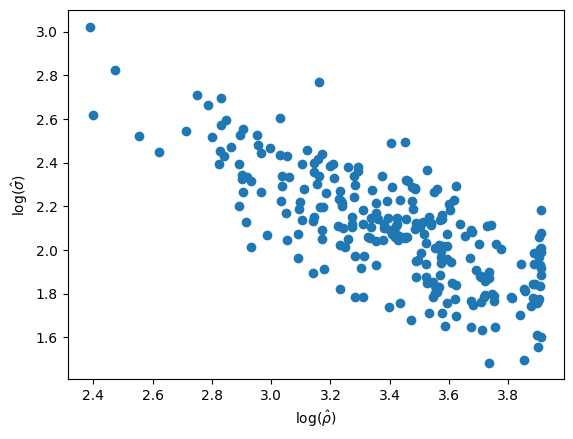

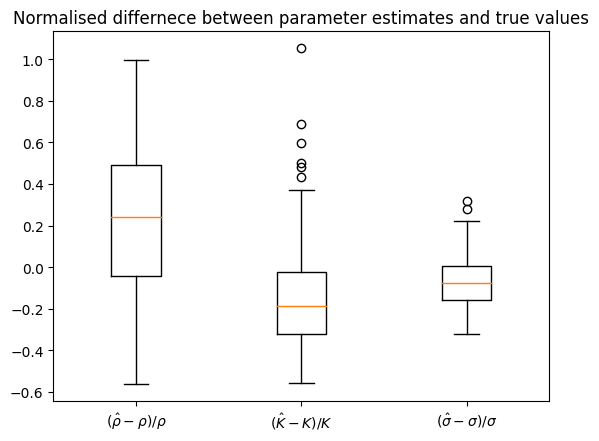

In [9]:
plt.figure(1);
plt.scatter(np.log(params[:,0]), np.log(params[:,1]));
plt.xlabel(r"$\log(\hat{\rho})$"); plt.ylabel(r"$\log(\hat{\sigma})$");

data = [(params[:,0]- rho)/rho, (params[:,1]- K)/K, (params[:,2]- sigma)/sigma]
fig7, ax7 = plt.subplots()
ax7.set_title('Normalised differnece between parameter estimates and true values')
ax7.boxplot(data)
plt.xticks([1, 2, 3], [r'$(\hat{\rho} - \rho)/\rho$',
                    r'$(\hat{K} - K)/K$', 
                    r'$(\hat{\sigma} - \sigma)/\sigma$'])
plt.show()

## Palm likelihood estimation
### Stability of estimates

Here we run $N_{pl}$ iterations of the Palm likelihood esimator, each time sampling from a Thomas process with fixed parameter values from iteration to iteration. Parameters are either sampled using a random grid search between provided bounds, or using a uniform grid between the same bounds. A default value of $R = 1/4$ will be used, where $R$ is the assumed range of correlation of the process.

In [10]:
rho = 50 # parent Poisson intensity
K = 25 # number of Offpsring Poisson rate
sigma = 0.03 # sd of offspring spatial distribution
cov = np.array([[1, 0], [0, 1]]) 

# Instatiate class for Thomas process
tom = SPP_Thomas()

N_pl = 250 # Number of repetitions

params = np.zeros((N_pl, 3))
for k in range(N_pl):
    if (((k+1) / 25) == ((k+1) // 25)):
        print(f"Run {k + 1} of {N_pl}")
    spp = tom.simSPP(rho, K, sigma, np.array([[1,0], [0, 1]]), 1.25)
    tpl = PalmLikelihoodThomas(spp, R=0.25)
    params[k, :] = (tpl.maximisePalmLikelihood(
                                rho_min=10, rho_max=50, 
                                K_min=5, K_max=20,
                                sig_min=0.01, sig_max=0.1,
                                coarseness=10,
                                random=True,
                                verbose=False))


Run 25 of 250
Run 50 of 250
Run 75 of 250
Run 100 of 250
Run 125 of 250
Run 150 of 250
Run 175 of 250
Run 200 of 250
Run 225 of 250
Run 250 of 250


In [11]:
print(f"""
        rho mean scaled bias: {np.mean((params[:,0]- rho)/rho)}
        K mean scaled bias: {np.mean((params[:,1]- K)/K)}
        sigma mean scaled bias: {np.mean((params[:,2]- sigma)/sigma)}

       """)


        rho mean scaled bias: -0.09928128885280474
        K mean scaled bias: -0.2555644077681568
        sigma mean scaled bias: 0.05238523519307353

       


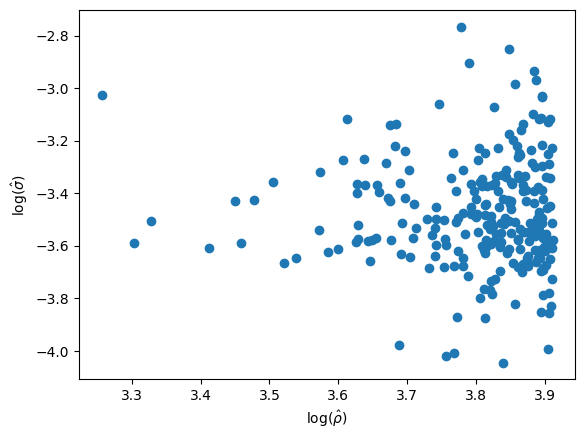

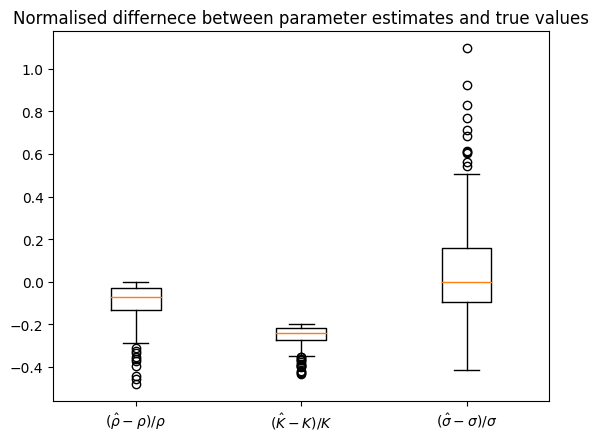

In [12]:
plt.figure(1);
plt.scatter(np.log(params[:,0]), np.log(params[:,2]));
plt.xlabel(r"$\log(\hat{\rho})$"); plt.ylabel(r"$\log(\hat{\sigma})$");

data = [(params[:,0]- rho)/rho, (params[:,1]-K)/K, (params[:,2]- sigma)/sigma]
fig7, ax7 = plt.subplots()
ax7.set_title('Normalised differnece between parameter estimates and true values')
ax7.boxplot(data)
plt.xticks([1, 2, 3], [r'$(\hat{\rho} - \rho)/\rho$',
                      r'$(\hat{K} - K)/K$',
                      r'$(\hat{\sigma} - \sigma)/\sigma$'])
plt.show()

Sample a Thomas process

## Whittle estimation
### Stability of estimates

Here we run $N_{w}$ iterations of the Whittle esimator, each time sampling from a Thomas process with fixed parameter values from iteration to iteration. Parameters are either sampled using a random grid search between provided bounds, or using a uniform grid between the same bounds.

In [3]:
rho = 25 # parent Poisson intensity
K = 10 # number of Offpsring Poisson rate
sigma = 0.03 # sd of offspring spatial distribution
cov = np.array([[1, 0], [0, 1]]) 

# Instatiate class for Thomas process
tom = SPP_Thomas()

N_w = int(2.5e2) # Number of repetitions

params = np.zeros((N_w, 4))
for k in range(N_w):
    if (((k+1) / 25) == ((k+1) // 25)):
        print(f"Run {k + 1} of {N_w}")
    spp = tom.simSPP(rho, K, sigma, cov, enlarge=1.25)
    params[k, 3] = len(spp)
    twe = ThomasWhittleEstimator(spp, -16, 16, 1)
    params[k, 0:3] = (twe.scipyOptimisation([15, 5, 0.05]))

Run 25 of 1000
Run 50 of 1000
Run 75 of 1000
Run 100 of 1000
Run 125 of 1000
Run 150 of 1000
Run 175 of 1000
Run 200 of 1000
Run 225 of 1000
Run 250 of 1000
Run 275 of 1000
Run 300 of 1000
Run 325 of 1000
Run 350 of 1000
Run 375 of 1000
Run 400 of 1000
Run 425 of 1000
Run 450 of 1000
Run 475 of 1000
Run 500 of 1000
Run 525 of 1000
Run 550 of 1000
Run 575 of 1000
Run 600 of 1000
Run 625 of 1000
Run 650 of 1000
Run 675 of 1000
Run 700 of 1000
Run 725 of 1000
Run 750 of 1000
Run 775 of 1000
Run 800 of 1000
Run 825 of 1000
Run 850 of 1000
Run 875 of 1000
Run 900 of 1000
Run 925 of 1000
Run 950 of 1000
Run 975 of 1000
Run 1000 of 1000


In [4]:
print(f"""
        rho mean scaled bias: {np.mean((params[:,0]- rho)/rho)}
        K mean scaled bias: {np.mean((params[:,1]- K)/K)}
        sigma mean scaled bias: {np.mean((params[:,2]- sigma)/sigma)}
       """)


        rho mean scaled bias: -0.22966063225602182
        K mean scaled bias: 0.36209521729714583
        sigma mean scaled bias: 0.07595959908121151
       


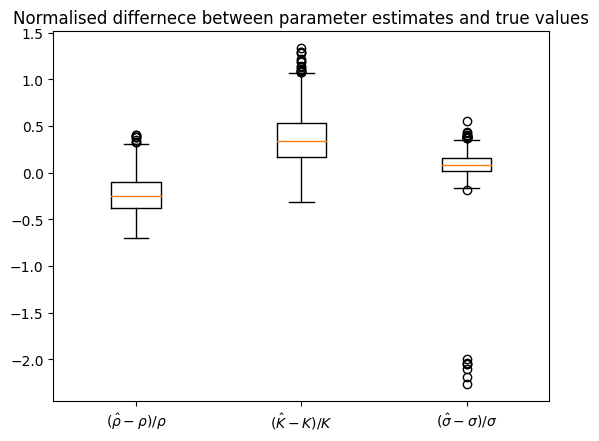

In [24]:
data = [(params[:,0]- rho)/rho, (params[:,1]-K)/K, (params[:,2]- sigma)/sigma]
fig7, ax7 = plt.subplots()
ax7.set_title('Normalised differnece between parameter estimates and true values')
ax7.boxplot(data)
plt.xticks([1, 2, 3], [r'$(\hat{\rho} - \rho)/\rho$',
                      r'$(\hat{K} - K)/K$',
                      r'$(\hat{\sigma} - \sigma)/\sigma$'])
plt.show()

In [62]:
print(f"""Index of dispersion for rho: {np.sqrt(np.var(params[:,0]))/np.mean(params[:,0])}""")
print(f"""Index of dispersion for K: {np.sqrt(np.var(params[:,1]))/np.mean(params[:,1])}""")
print(f"""Index of dispersion for sigma: {np.sqrt(np.var(params[:,2]))/np.mean(params[:,2])}""")

Index of dispersion for rho: 0.26649808969182676
Index of dispersion for K: 0.20162827859669846
Index of dispersion for sigma: 0.19528897730157965


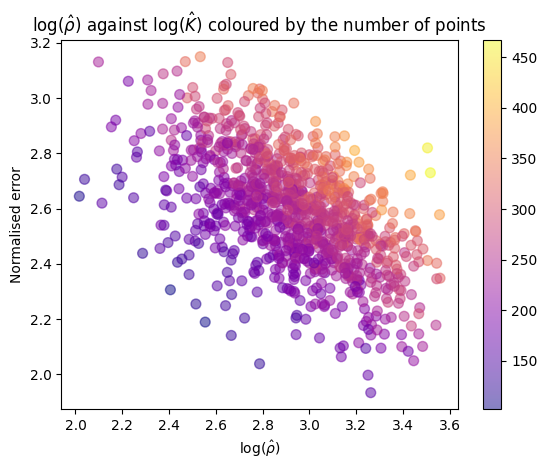

In [50]:
f, ax = plt.subplots();
points = ax.scatter(np.log(params[:,0]), np.log(params[:,1]), 
                    c=params[:,3], s=50, cmap="plasma",
                    alpha=0.5);
f.colorbar(points)
plt.xlabel(r"$\log(\hat{\rho})$"); plt.ylabel(r"$\log(\hat{K})$");
plt.ylabel("Normalised error");
plt.title(r"""$\log(\hat{\rho})$ against $\log(\hat{K})$ coloured by the number of points""");

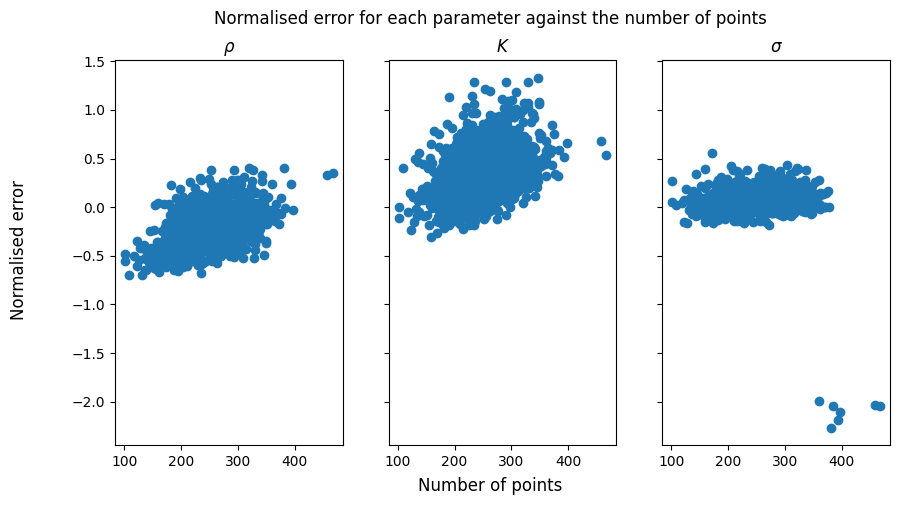

In [51]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5), sharey=True)
ax1.scatter(params[:,3], (params[:,0] - rho)/rho); ax1.set_title(r"$\rho$");
ax2.scatter(params[:,3], (params[:,1] - K)/K); ax2.set_title(r"$K$");
ax3.scatter(params[:,3], (params[:,2] - sigma)/sigma); ax3.set_title(r"$\sigma$");
fig.supxlabel("Number of points"); fig.supylabel("Normalised error");
fig.suptitle("Normalised error for each parameter against the number of points");

## KMeans estimation
### Stability of estimates

Here we run $N_{km}$ iterations of the KMeans esimator, each time sampling from a Thomas process with fixed parameter values from iteration to iteration. Parameters are either sampled using a random grid search between provided bounds, or using a uniform grid between the same bounds.

In [16]:
rho = 25 # parent Poisson intensity
K = 10 # number of Offpsring Poisson rate
sigma = 0.03 # sd of offspring spatial distribution
cov = np.array([[1, 0], [0, 1]]) 

# Number of KMeans repetitions
N_km = 250

# Instatiate class for Thomas process
tom = SPP_Thomas()

params = np.zeros((N_km, 3))
for i in range(N_km):
    if ((i+1)/10 == (i+1)//10):
        print(f"Iteration {i+1} of {N_km}")

    spp = tom.simSPP(rho, K, sigma, cov, enlarge=1.25)

    kme = KMeansEstimation(spp)
    num_clusters = kme.selectNumberOfClusters()

    params[i, :] =  kme.computeEstimators(num_clusters)

Iteration 10 of 250
Iteration 20 of 250
Iteration 30 of 250
Iteration 40 of 250
Iteration 50 of 250
Iteration 60 of 250
Iteration 70 of 250
Iteration 80 of 250
Iteration 90 of 250
Iteration 100 of 250
Iteration 110 of 250
Iteration 120 of 250
Iteration 130 of 250
Iteration 140 of 250
Iteration 150 of 250
Iteration 160 of 250
Iteration 170 of 250
Iteration 180 of 250
Iteration 190 of 250
Iteration 200 of 250
Iteration 210 of 250
Iteration 220 of 250
Iteration 230 of 250
Iteration 240 of 250
Iteration 250 of 250


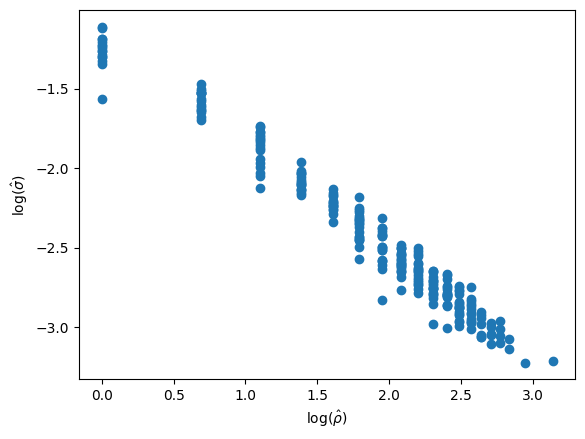

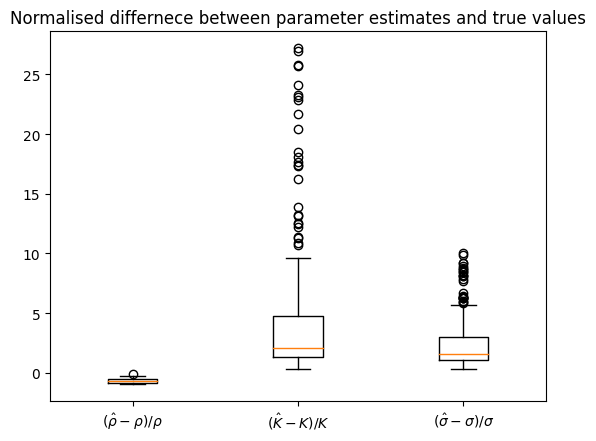

In [17]:
plt.figure(1);
plt.scatter(np.log(params[:,0]), np.log(params[:,2]));
plt.xlabel(r"$\log(\hat{\rho})$"); plt.ylabel(r"$\log(\hat{\sigma})$");

data = [(params[:,0]- rho)/rho, (params[:,1]-K)/K, (params[:,2]- sigma)/sigma]
fig7, ax7 = plt.subplots()
ax7.set_title('Normalised differnece between parameter estimates and true values')
ax7.boxplot(data)
plt.xticks([1, 2, 3], [r'$(\hat{\rho} - \rho)/\rho$',
                      r'$(\hat{K} - K)/K$',
                      r'$(\hat{\sigma} - \sigma)/\sigma$'])
plt.show()

In [18]:
print(f"""
        rho mean scaled bias: {np.mean((params[:,0]- rho)/rho)}
        K mean scaled bias: {np.mean((params[:,1]- K)/K)}
        sigma mean scaled bias: {np.mean((params[:,2]- sigma)/sigma)}

       """)


        rho mean scaled bias: -0.69152
        K mean scaled bias: 4.331259810845964
        sigma mean scaled bias: 2.4548077547136464

       


None
